- 与训练端到端（从像素到分类结果）系统不同，经典机器学习的流水线看起来更像下面这样：
1. 获取一个有趣的数据集。在早期，收集这些数据集需要昂贵的传感器（在当时最先进的图像也就100万像素）。
2. 根据光学、几何学、其他知识以及偶然的发现，手工对特征数据集进行预处理。
3. 通过标准的特征提取算法，如SIFT（尺度不变特征变换）(Lowe, 2004)和SURF（加速鲁棒特征）(Bay etal., 2006)或其他手动调整的流水线来输入数据。
4. 将提取的特征送入最喜欢的分类器中（例如线性模型或其它核方法），以训练分类器。
- 另一种预测这个领域发展的方法————观察图像特征的提取方法。在2012年前，图像特征都是机械地计算出来的。事实上，设计一套新的特征函数、改进结果，并撰写论文是盛极一时的潮流。
- 另外一些研究人员的想法却与众不同，他们认为特征本身应该被学习。此外，他们还认为，在合理地复杂性前提下，特征应该由多个共同学习的神经网络层组成，每个层都有可学习的参数。在机器视觉中，最底层可能检测边缘、颜色和纹理。

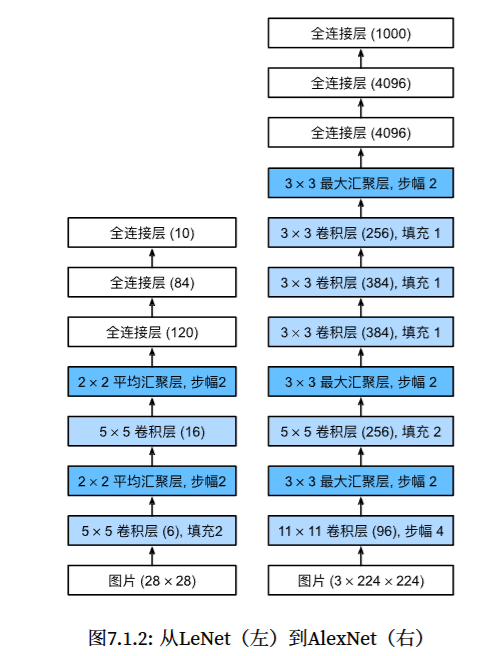

AlexNet和LeNet的设计理念非常相似，但也存在显著差异。
1. AlexNet比相对较小的LeNet5要深得多。AlexNet由八层组成：五个卷积层、两个全连接隐藏层和一个全连接输出层。
2. AlexNet使用ReLU而不是sigmoid作为其激活函数。
3. AlexNet的卷积通道数目是LeNet的10倍。

In [5]:
import torch
from torch import nn
from d2l import torch as d2l

net=nn.Sequential(
    # 这里使用一个11*11的更大窗口来捕捉对象。
    # 同时，步幅为4，以减少输出的高度和宽度。
    # 另外，输出通道的数目远大于LeNet
    nn.Conv2d(1,96,kernel_size=11,stride=4,padding=1),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2),
    #减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
    nn.Conv2d(96,256,kernel_size=5,padding=2),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2),
    #使用三个连续的卷积层和较小的卷积窗口。
    #除了最后的卷积层，输出通道的数量进一步增加。
    #在前两个卷积层之后，汇聚层不用于减少输入的高度和宽度
    nn.Conv2d(256,384,kernel_size=3,padding=1),nn.ReLU(),
    nn.Conv2d(384,384,kernel_size=3,padding=1),nn.ReLU(),
    nn.Conv2d(384,256,kernel_size=3,padding=1),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2),
    nn.Flatten(),
    #这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
    nn.Linear(6400,4096),nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096,4096),nn.ReLU(),
    nn.Dropout(p=0.5),
    #最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
    nn.Linear(4096,10)
)
#我们构造一个高度和宽度都为224的单通道数据来观察每一层的输出形状，它与图7.1.2中的AlexNet架构相匹配
X=torch.randn(1,1,224,224)
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

尽管原文中AlexNet是在ImageNet上进行训练的，但本书在这里使用的是Fashion‐MNIST数据集。因为即使在现代GPU上，训练ImageNet模型，同时使其收敛可能需要数小时或数天的时间。将AlexNet直接应用于Fashion‐MNIST的一个问题是，Fashion‐MNIST图像的分辨率（28 × 28像素）低于ImageNet图像。为了解决这个问题，我们将它们增加到224 × 224（通常来讲这不是一个明智的做法，但在这里这样做是为了有效使用AlexNet架构）。这里需要使用d2l.load_data_fashion_mnist函数中的resize参数执行此调整。

In [6]:
batch_size=128
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size,resize=224)

loss 0.332, train acc 0.878, test acc 0.879
1421.3 examples/sec on cuda:0


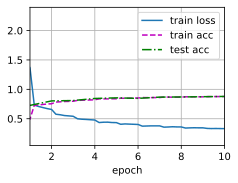

In [7]:
#训练AlexNet
#与 6.6节中的LeNet相比，这里的主要变化是使用更小的学习速率训练，这是因为网络更深更广、图像分辨率更高，训练卷积神经网络就更昂贵。
lr,num_epochs=0.01,10
d2l.train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())